# MO Matching Validation 

### The MOs between them only have in common the RunNumber. 
 
### In special cases the 'CycleNumber' is being provided which allows for perfect matching bewteen the objects. 


### However, in our case we need to compare their creation time and keep the ones that were created almost at the same time --> with a window of 10 minutes or more. 

In [1]:
import json 
import pandas as pd 
import os 

BASE_PATH = os.getcwd()

with open(os.path.join(BASE_PATH, "qcdb_data/qc/TPC/MO/Clusters/c_Sides_N_Clusters.json"), "r") as f: 
    data = json.load(f)
    
cluster_version_metadata = pd.json_normalize(data)
cluster_version_metadata

import json
with open("/Users/zetasourpi/Desktop/ai-qc/AI-for-data-quality-control/tpc-autoencoder-clean/data-ingestion/qcdb_data/qc/TPC/MO/Q_O_physics/QualitySummary.json", "r") as f: 
    quality_summ_version_metadata = json.load(f)
    
quality_summ_version_metadata = pd.json_normalize(quality_summ_version_metadata)

with open(os.path.join(BASE_PATH, 'bkkp_data/runs_stable_beams_with_good_tpc_quality.json') , "r") as bkkpruns: 
    bkkp_good_runs = json.load(bkkpruns)
    
bkkp_good_runs_df = pd.json_normalize(bkkp_good_runs)

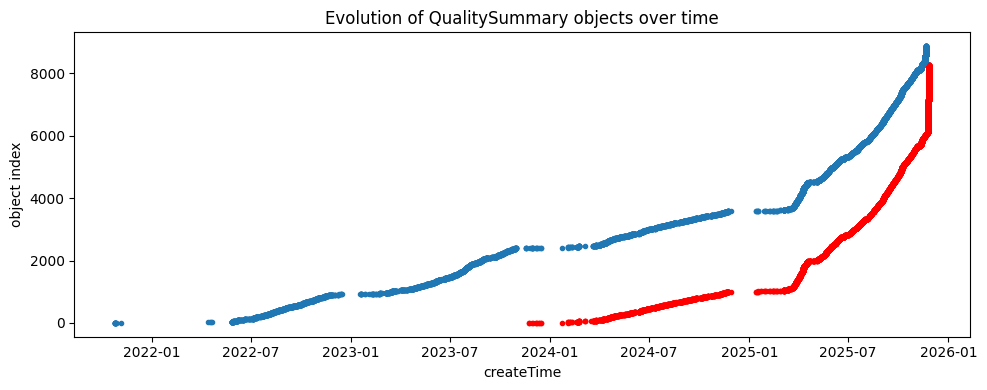

In [2]:
qs = quality_summ_version_metadata.copy()

qs["createTime_dt"] = pd.to_datetime(qs["createTime"], unit="ms")
qs = qs.sort_values("createTime_dt").reset_index(drop=True)

clusters = cluster_version_metadata.copy()

clusters["createTime_dt"] = pd.to_datetime(clusters["createTime"], unit="ms")
clusters = clusters.sort_values("createTime_dt").reset_index(drop=True)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(qs["createTime_dt"], range(len(qs)), marker=".", linestyle="none", color="red")
plt.plot(clusters["createTime_dt"], range(len(clusters)), marker=".", linestyle="none")

plt.xlabel("createTime")
plt.ylabel("object index")
plt.title("Evolution of QualitySummary objects over time")
plt.tight_layout()
plt.show()


In [4]:
import plotly.graph_objects as go

# 1) Compute overlap (same as before)
qs_min = qs["createTime_dt"].min()
qs_max = qs["createTime_dt"].max()

cl_min = clusters["createTime_dt"].min()
cl_max = clusters["createTime_dt"].max()

overlap_start = max(qs_min, cl_min)
overlap_end   = min(qs_max, cl_max)

print("Overlap:", overlap_start, "→", overlap_end)

qs_overlap = qs[(qs["createTime_dt"] >= overlap_start) &
                (qs["createTime_dt"] <= overlap_end)].reset_index(drop=True)

clusters_overlap = clusters[(clusters["createTime_dt"] >= overlap_start) &
                            (clusters["createTime_dt"] <= overlap_end)].reset_index(drop=True)

# 2) Build interactive Plotly figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=qs_overlap["createTime_dt"],
        y=list(range(len(qs_overlap))),
        mode="markers",
        name="QSum",
        marker=dict(size=5, color="red"),
    )
)

fig.add_trace(
    go.Scatter(
        x=clusters_overlap["createTime_dt"],
        y=list(range(len(clusters_overlap))),
        mode="markers",
        name="Clusters",
        marker=dict(size=5, color="blue"),
    )
)

fig.update_layout(
    title="Evolution of objects over time (overlapping region)",
    xaxis_title="createTime",
    yaxis_title="object index (overlap only)",
    height=400,
)

fig.show()

Overlap: 2023-11-23 20:56:08.080000 → 2025-11-21 15:21:16.577000


# Case 1 
### When N_Cluster >> N_Qsum (because the policies are different) --> Seen in most recent data

In [ ]:
import json 
import pandas as pd 
import os 
import math, os, sys, re
from pathlib import Path
from datetime import datetime

from array import array
import numpy as np
from tqdm.auto import tqdm 
import shutil 
import logging 

try:
    import ROOT 
except Exception as e:
    raise SystemExit("PyROOT import failed. Make sure your kernel uses the env with ROOT installed.\n" + str(e))

from utils import load_json_file_into_df, load_quality_summ_from_root_objects, config_logger, plot_qs_cluster_per_run_number

def filter_mo_based_on_quality_summaries(BASE_PATH, qcdb_mo_json_data_REL_PATH, bkkp_json_data_REL_PATH, qcdb_qs_mo_json_data_REL_PATH, qual_val_pairs, dst): 
    # metadata regards the versions of the objects 
    # an object is a path (ex. qc/TPC/MO/Clusters/c_Sides_N_Clusters), a version is one item in that path
    # mo could be an occupancy map, a cluster map, a graph etc. 
    mo_metadata = load_json_file_into_df(os.path.join(os.getcwd(), qcdb_mo_json_data_REL_PATH))    
    bkkp_filtered_runs =  load_json_file_into_df(os.path.join(os.getcwd(), bkkp_json_data_REL_PATH))   
    quality_summ_mo_metadata = load_json_file_into_df(os.path.join(os.getcwd(), qcdb_qs_mo_json_data_REL_PATH))    

    # Filter mo ex. cluster metadata based on wanted filters ex. the good runs loaded from book-keeping
        # Ensure same dtypes
    mo_metadata['RunNumber_int64'] = mo_metadata['RunNumber'].astype("int64") 
    quality_summ_mo_metadata['RunNumber_int64'] = mo_metadata['RunNumber'].astype("int64") 

    quality_summ_mo_metadata['RunNumber_int64'] = quality_summ_mo_metadata['RunNumber'].astype("int64") 
    bkkp_filtered_runs['runNumber_int64'] = bkkp_filtered_runs['runNumber']

        # Keep the MOs that exist in book-keeping 
    mo_metadata_bbkp_filtered = ( mo_metadata.loc[   mo_metadata['RunNumber_int64'].isin(bkkp_filtered_runs['runNumber_int64'])   ]
                                                .reset_index(drop=True) ) 

        # statistics to keep in mind 
    precentage = int(len(mo_metadata_bbkp_filtered) * 100/ len(mo_metadata))
    logger.info(f"{len(mo_metadata_bbkp_filtered)}/{len(mo_metadata)} or {precentage}% of cluster data (versions) are from the runs based on book-keeping filtering.")
    logger.info(f"The total number of runs taken into consideration from api bkkp limit --> {len(bkkp_filtered_runs)}")

    # Filter the mo ex. clusters FURTHER by a quality metric of the quality summaries loaded from qcdb 
    quality_dict = load_quality_summ_from_root_objects(filepath_of_root_objects= os.path.join(os.getcwd(), "qcdb_data/qc/TPC/MO/Q_O_physics/QualitySummary/"))

        # Chosen quality metric ex. Raw Occupancy quality is "Good"
    filtered_quality_summ_obj_names = [
        key 
        for key, value in quality_dict.items()
        if (
            not qual_val_pairs
            or all(value.get(q) == exp for q, exp in qual_val_pairs)
        )
    ]
        # stats
    logger.info(  f"{len(filtered_quality_summ_obj_names)}/{len(quality_dict)} quality summaries have the desired quality metrics {qual_val_pairs}")

        # However, the Root names are not the same across MOs! 
            # --> We need to correlate these objects with their corresponding Run Number and Creation Time (found on the object metadata)
    mask_metric = quality_summ_mo_metadata["fileName"].isin(filtered_quality_summ_obj_names)
    mask_runs = quality_summ_mo_metadata["RunNumber_int64"].isin(bkkp_filtered_runs["runNumber_int64"])


    quality_summ_mo_metadata_filtered = (
        quality_summ_mo_metadata[mask_metric & mask_runs]
        .reset_index(drop=True)
    )
        # stats
    logger.info(f"{len(quality_summ_mo_metadata_filtered)}/{len(quality_summ_mo_metadata)} or {int(len(quality_summ_mo_metadata_filtered) * 100 /len(quality_summ_mo_metadata))}% of quality summary objects have the specified filters.")

    ### CONCATENATE (put one on top of the other) the cluster data with the good quality summaries 
    # The only column they have in common is the 'RunNumber', so we group by it and then compare the creation times of the objects

    concat_mo_with_qsum_mo = pd.concat([mo_metadata_bbkp_filtered, quality_summ_mo_metadata_filtered], ignore_index=True)

    common_runs = set(mo_metadata_bbkp_filtered["RunNumber_int64"]).intersection(quality_summ_mo_metadata_filtered["RunNumber_int64"])
    logger.info(f"Number of commons runs between the mo and the quality summaries: {len(common_runs)}, Number of unique runs in mo data {len(set(mo_metadata_bbkp_filtered["RunNumber_int64"]))}, Number of unique runs in quality summaries {len(set(quality_summ_mo_metadata_filtered["RunNumber"]))}")

    concat_mo_with_qsum_mo = concat_mo_with_qsum_mo[ concat_mo_with_qsum_mo['RunNumber_int64'].isin(common_runs) ] 

    concat_mo_with_qsum_mo_group_by_run_number = concat_mo_with_qsum_mo.groupby("RunNumber_int64")
    n_groups = len(concat_mo_with_qsum_mo_group_by_run_number)
        
    # Create destination folder for the objects to keep
    os.makedirs(dst, exist_ok=True)

    global_idxs_saved = set()

    for _, group_df in tqdm(iterable=concat_mo_with_qsum_mo_group_by_run_number, total = n_groups, desc="Processing run groups"):
        
        mo_path = os.path.join(os.path.dirname(qcdb_mo_json_data_REL_PATH).replace("qcdb_data/", ""),
                                os.path.splitext(os.path.basename(qcdb_mo_json_data_REL_PATH))[0])

        qsum_path =os.path.join(os.path.dirname(qcdb_qs_mo_json_data_REL_PATH).replace("qcdb_data/", ""),
                                os.path.splitext(os.path.basename(qcdb_qs_mo_json_data_REL_PATH))[0])
        
        num_mo_objects = group_df.path.value_counts()[mo_path]
        num_qsum_mo_objects = group_df.path.value_counts()[qsum_path] 
        

        if num_mo_objects >=5 and num_qsum_mo_objects >= 5 and num_mo_objects>num_qsum_mo_objects:
                
                ref_times_series = group_df.loc[group_df["path"] == qsum_path, "createTime"]
                cl_times_series = group_df.loc[group_df["path"] == mo_path, "createTime"]
                
                for i in range(num_qsum_mo_objects): 
                    ref_time = ref_times_series.iloc[i] # ref times of qsum object! 
                    group_df[f"diff_min"] = (group_df["createTime"] - ref_time).abs() / 1000 / 60
                    
                    group_df["createTime_dt"] = pd.to_datetime(group_df["createTime"], unit="ms")
                    
                    # To debug and plot the cluster and quality summary timestamps
                    # logger.info("\n%s", group_df[["path", "RunNumber", "createTime_dt", f"diff_min"]])
                    plot_qs_cluster_per_run_number(ref_times_series, cl_times_series, group_df["RunNumber"].iloc[0])
                    
                    # only keep clusters that are within 10 min of the qsum ref time 
                    mask_valid = (group_df["path"] == mo_path) & (group_df[f"diff_min"]  < 10)

                    valid_idxs = group_df.index[mask_valid]
                    
                    logger.info(pd.to_datetime(ref_time, unit="ms"))
                    logger.info(group_df.loc[valid_idxs, "createTime_dt"])
                    logger.info(valid_idxs)
                    input()
                    #logger.info(valid_idxs)
                    
                    for idx in [i for i in valid_idxs if i not in global_idxs_saved]:
                        global_idxs_saved.add(idx)
                        fname = group_df.loc[idx, "fileName"]
                        continue
                        # src = os.path.join(
                        #     BASE_PATH,
                        #     qcdb_mo_json_data_REL_PATH.removesuffix(".json"),
                        #     fname,
                        # )
                        # shutil.copy(src, os.path.join(dst, fname))

                    group_df.drop('diff_min', axis=1, inplace=True)

        else:
            continue
            logger.critical("Either qsum or clusters don't exist.")
            print(group_df[["path", "RunNumber", "createTime"]])
            sys.exit(True)
            
    logger.info(f"{len(global_idxs_saved)}/{len(mo_metadata_bbkp_filtered)} total files were kept in the dst folder: {dst}")
    
    
    
if __name__ == '__main__': 

    logger = config_logger()
    BASE_PATH = os.getcwd()
    qcdb_mo_json_data_REL_PATH = "data/qcdb_data/qc/TPC/MO/Clusters/c_Sides_N_Clusters.json"
    bkkp_json_data_REL_PATH = "data/bkkp_data/runs_stable_beams_with_good_tpc_quality.json"
    qcdb_qs_mo_json_data_REL_PATH = "data/qcdb_data/qc/TPC/MO/Q_O_physics/QualitySummary.json"
    dest_folder = os.path.join(BASE_PATH, os.path.dirname(qcdb_mo_json_data_REL_PATH), "filtered_clusters")

    # qual_val_pairs = [("Raw occupancy quality","Good"), ("Cluster occupancy quality","Bad")]
    filter_mo_based_on_quality_summaries(BASE_PATH, qcdb_mo_json_data_REL_PATH, bkkp_json_data_REL_PATH, qcdb_qs_mo_json_data_REL_PATH, qual_val_pairs = [], dst=dest_folder)


2025-12-05 16:51:37,070 - INFO - Logger initialized
2025-12-05 16:51:37,268 - INFO - 3618/8874 or 40% of cluster data (versions) are from the runs based on book-keeping filtering.
2025-12-05 16:51:37,268 - INFO - The total number of runs taken into consideration from api bkkp limit --> 1444


Extracting quality summary from root object: TObject_1702371993522.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1709562934573.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1700773546213.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1710520352344.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1709562641539.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1700772968078.root, with error: list assignment index out of range


2025-12-05 16:51:41,696 - INFO - 10991/10991 quality summaries have the desired quality metrics []
2025-12-05 16:51:41,699 - INFO - 3862/8268 or 46% of quality summary objects have the specified filters.
2025-12-05 16:51:41,701 - INFO - Number of commons runs between the mo and the quality summaries: 904, Number of unique runs in mo data 1383, Number of unique runs in quality summaries 914


Processing run groups:   0%|          | 0/904 [00:00<?, ?it/s]

2025-12-05 16:51:41,864 - INFO - 2025-11-20 03:37:36.592000
2025-12-05 16:51:41,865 - INFO - 149   2025-11-20 03:37:06.861
150   2025-11-20 03:34:06.747
151   2025-11-20 03:31:06.635
152   2025-11-20 03:28:06.457
Name: createTime_dt, dtype: datetime64[ns]
2025-12-05 16:51:41,866 - INFO - Index([149, 150, 151, 152], dtype='int64')


2025-12-05 16:52:38,757 - INFO - 2025-11-20 03:06:35.165000
2025-12-05 16:52:38,757 - INFO - 156   2025-11-20 03:16:05.851
157   2025-11-20 03:13:05.654
158   2025-11-20 03:10:05.531
159   2025-11-20 03:07:05.401
160   2025-11-20 03:04:05.254
161   2025-11-20 03:01:05.094
162   2025-11-20 02:58:04.929
Name: createTime_dt, dtype: datetime64[ns]
2025-12-05 16:52:38,758 - INFO - Index([156, 157, 158, 159, 160, 161, 162], dtype='int64')


KeyboardInterrupt: Interrupted by user

# Case 2 
### When N_Qsum > N_Cluster --> All clusters end up to remain, because of the overlap. --> We do a per Qsum scan for clusters. 

In [6]:
import json 
import pandas as pd 
import os 
import math, os, sys, re
from pathlib import Path
from datetime import datetime

from array import array
import numpy as np
from tqdm.auto import tqdm 
import shutil 
import logging 

try:
    import ROOT 
except Exception as e:
    raise SystemExit("PyROOT import failed. Make sure your kernel uses the env with ROOT installed.\n" + str(e))

from utils import load_json_file_into_df, load_quality_summ_from_root_objects, config_logger, plot_qs_cluster_per_run_number

def filter_mo_based_on_quality_summaries(BASE_PATH, qcdb_mo_json_data_REL_PATH, bkkp_json_data_REL_PATH, qcdb_qs_mo_json_data_REL_PATH, qual_val_pairs, dst): 
    # metadata regards the versions of the objects 
    # an object is a path (ex. qc/TPC/MO/Clusters/c_Sides_N_Clusters), a version is one item in that path
    # mo could be an occupancy map, a cluster map, a graph etc. 
    mo_metadata = load_json_file_into_df(os.path.join(os.getcwd(), qcdb_mo_json_data_REL_PATH))    
    bkkp_filtered_runs =  load_json_file_into_df(os.path.join(os.getcwd(), bkkp_json_data_REL_PATH))   
    quality_summ_mo_metadata = load_json_file_into_df(os.path.join(os.getcwd(), qcdb_qs_mo_json_data_REL_PATH))    

    # Filter mo ex. cluster metadata based on wanted filters ex. the good runs loaded from book-keeping
        # Ensure same dtypes
    mo_metadata['RunNumber_int64'] = mo_metadata['RunNumber'].astype("int64") 
    quality_summ_mo_metadata['RunNumber_int64'] = mo_metadata['RunNumber'].astype("int64") 

    quality_summ_mo_metadata['RunNumber_int64'] = quality_summ_mo_metadata['RunNumber'].astype("int64") 
    bkkp_filtered_runs['runNumber_int64'] = bkkp_filtered_runs['runNumber']

        # Keep the MOs that exist in book-keeping 
    mo_metadata_bbkp_filtered = ( mo_metadata.loc[   mo_metadata['RunNumber_int64'].isin(bkkp_filtered_runs['runNumber_int64'])   ]
                                                .reset_index(drop=True) ) 

        # statistics to keep in mind 
    precentage = int(len(mo_metadata_bbkp_filtered) * 100/ len(mo_metadata))
    logger.info(f"{len(mo_metadata_bbkp_filtered)}/{len(mo_metadata)} or {precentage}% of cluster data (versions) are from the runs based on book-keeping filtering.")
    logger.info(f"The total number of runs taken into consideration from api bkkp limit --> {len(bkkp_filtered_runs)}")

    # Filter the mo ex. clusters FURTHER by a quality metric of the quality summaries loaded from qcdb 
    quality_dict = load_quality_summ_from_root_objects(filepath_of_root_objects= os.path.join(os.getcwd(), "qcdb_data/qc/TPC/MO/Q_O_physics/QualitySummary/"))

        # Chosen quality metric ex. Raw Occupancy quality is "Good"
    filtered_quality_summ_obj_names = [
        key 
        for key, value in quality_dict.items()
        if (
            not qual_val_pairs
            or all(value.get(q) == exp for q, exp in qual_val_pairs)
        )
    ]
        # stats
    logger.info(  f"{len(filtered_quality_summ_obj_names)}/{len(quality_dict)} quality summaries have the desired quality metrics {qual_val_pairs}")

        # However, the Root names are not the same across MOs! 
            # --> We need to correlate these objects with their corresponding Run Number and Creation Time (found on the object metadata)
    mask_metric = quality_summ_mo_metadata["fileName"].isin(filtered_quality_summ_obj_names)
    mask_runs = quality_summ_mo_metadata["RunNumber_int64"].isin(bkkp_filtered_runs["runNumber_int64"])


    quality_summ_mo_metadata_filtered = (
        quality_summ_mo_metadata[mask_metric & mask_runs]
        .reset_index(drop=True)
    )
        # stats
    logger.info(f"{len(quality_summ_mo_metadata_filtered)}/{len(quality_summ_mo_metadata)} or {int(len(quality_summ_mo_metadata_filtered) * 100 /len(quality_summ_mo_metadata))}% of quality summary objects have the specified filters.")

    ### CONCATENATE (put one on top of the other) the cluster data with the good quality summaries 
    # The only column they have in common is the 'RunNumber', so we group by it and then compare the creation times of the objects

    concat_mo_with_qsum_mo = pd.concat([mo_metadata_bbkp_filtered, quality_summ_mo_metadata_filtered], ignore_index=True)

    common_runs = set(mo_metadata_bbkp_filtered["RunNumber_int64"]).intersection(quality_summ_mo_metadata_filtered["RunNumber_int64"])
    logger.info(f"Number of commons runs between the mo and the quality summaries: {len(common_runs)}, Number of unique runs in mo data {len(set(mo_metadata_bbkp_filtered["RunNumber_int64"]))}, Number of unique runs in quality summaries {len(set(quality_summ_mo_metadata_filtered["RunNumber"]))}")

    concat_mo_with_qsum_mo = concat_mo_with_qsum_mo[ concat_mo_with_qsum_mo['RunNumber_int64'].isin(common_runs) ] 

    concat_mo_with_qsum_mo_group_by_run_number = concat_mo_with_qsum_mo.groupby("RunNumber_int64")
    n_groups = len(concat_mo_with_qsum_mo_group_by_run_number)
        
    # Create destination folder for the objects to keep
    os.makedirs(dst, exist_ok=True)

    global_idxs_saved = set()

    for _, group_df in tqdm(iterable=concat_mo_with_qsum_mo_group_by_run_number, total = n_groups, desc="Processing run groups"):
        
        mo_path = os.path.join(os.path.dirname(qcdb_mo_json_data_REL_PATH).replace("qcdb_data/", ""),
                                os.path.splitext(os.path.basename(qcdb_mo_json_data_REL_PATH))[0])

        qsum_path =os.path.join(os.path.dirname(qcdb_qs_mo_json_data_REL_PATH).replace("qcdb_data/", ""),
                                os.path.splitext(os.path.basename(qcdb_qs_mo_json_data_REL_PATH))[0])
        
        num_mo_objects = group_df.path.value_counts()[mo_path]
        num_qsum_mo_objects = group_df.path.value_counts()[qsum_path] 
        

        if num_mo_objects >=3 and num_qsum_mo_objects >= 3 and num_mo_objects < num_qsum_mo_objects:
                
                ref_times_series = group_df.loc[group_df["path"] == qsum_path, "createTime"]
                cl_times_series = group_df.loc[group_df["path"] == mo_path, "createTime"]
                
                for i in range(num_qsum_mo_objects): 
                    ref_time = ref_times_series.iloc[i] # ref times of qsum object! 
                    group_df[f"diff_min"] = (group_df["createTime"] - ref_time).abs() / 1000 / 60
                    
                    group_df["createTime_dt"] = pd.to_datetime(group_df["createTime"], unit="ms")
                    
                    # To debug and plot the cluster and quality summary timestamps
                    # logger.info("\n%s", group_df[["path", "RunNumber", "createTime_dt", f"diff_min"]])
                    plot_qs_cluster_per_run_number(ref_times_series, cl_times_series, group_df["RunNumber"].iloc[0])
                    
                    # only keep clusters that are within 10 min of the qsum ref time 
                    mask_valid = (group_df["path"] == mo_path) & (group_df[f"diff_min"]  < 10)

                    valid_idxs = group_df.index[mask_valid]
                    
                    logger.info(pd.to_datetime(ref_time, unit="ms"))
                    logger.info(group_df.loc[valid_idxs, "createTime_dt"])
                    logger.info(valid_idxs)
                    input()
                    #logger.info(valid_idxs)
                    
                    for idx in [i for i in valid_idxs if i not in global_idxs_saved]:
                        global_idxs_saved.add(idx)
                        fname = group_df.loc[idx, "fileName"]
                        continue
                        # src = os.path.join(
                        #     BASE_PATH,
                        #     qcdb_mo_json_data_REL_PATH.removesuffix(".json"),
                        #     fname,
                        # )
                        # shutil.copy(src, os.path.join(dst, fname))

                    group_df.drop('diff_min', axis=1, inplace=True)

        else:
            continue
            logger.critical("Either qsum or clusters don't exist.")
            print(group_df[["path", "RunNumber", "createTime"]])
            sys.exit(True)
            
    logger.info(f"{len(global_idxs_saved)}/{len(mo_metadata_bbkp_filtered)} total files were kept in the dst folder: {dst}")
    
    
    
if __name__ == '__main__': 

    logger = config_logger()
    BASE_PATH = os.getcwd()
    qcdb_mo_json_data_REL_PATH = "qcdb_data/qc/TPC/MO/Clusters/c_Sides_N_Clusters.json"
    bkkp_json_data_REL_PATH = "bkkp_data/runs_stable_beams_with_good_tpc_quality.json"
    qcdb_qs_mo_json_data_REL_PATH = "qcdb_data/qc/TPC/MO/Q_O_physics/QualitySummary.json"
    dest_folder = os.path.join(BASE_PATH, os.path.dirname(qcdb_mo_json_data_REL_PATH), "filtered_clusters")

    # qual_val_pairs = [("Raw occupancy quality","Good"), ("Cluster occupancy quality","Bad")]
    filter_mo_based_on_quality_summaries(BASE_PATH, qcdb_mo_json_data_REL_PATH, bkkp_json_data_REL_PATH, qcdb_qs_mo_json_data_REL_PATH, qual_val_pairs = [], dst=dest_folder)


2025-12-05 16:53:40,544 - INFO - 3618/8874 or 40% of cluster data (versions) are from the runs based on book-keeping filtering.
2025-12-05 16:53:40,544 - INFO - The total number of runs taken into consideration from api bkkp limit --> 1444


Extracting quality summary from root object: TObject_1702371993522.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1709562934573.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1700773546213.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1710520352344.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1709562641539.root, with error: list assignment index out of range
Extracting quality summary from root object: TObject_1700772968078.root, with error: list assignment index out of range


2025-12-05 16:53:44,271 - INFO - 10991/10991 quality summaries have the desired quality metrics []
2025-12-05 16:53:44,274 - INFO - 3862/8268 or 46% of quality summary objects have the specified filters.
2025-12-05 16:53:44,276 - INFO - Number of commons runs between the mo and the quality summaries: 904, Number of unique runs in mo data 1383, Number of unique runs in quality summaries 914


Processing run groups:   0%|          | 0/904 [00:00<?, ?it/s]

2025-12-05 16:53:44,381 - INFO - 2025-05-25 10:05:10.133000
2025-12-05 16:53:44,382 - INFO - 2515   2025-05-25 10:03:41.860
Name: createTime_dt, dtype: datetime64[ns]
2025-12-05 16:53:44,383 - INFO - Index([2515], dtype='int64')


2025-12-05 16:54:01,518 - INFO - 2025-05-25 09:57:39.757000
2025-12-05 16:54:01,518 - INFO - 2515   2025-05-25 10:03:41.860
Name: createTime_dt, dtype: datetime64[ns]
2025-12-05 16:54:01,519 - INFO - Index([2515], dtype='int64')


2025-12-05 16:54:25,253 - INFO - 2025-05-25 08:57:36.895000
2025-12-05 16:54:25,254 - INFO - 2516   2025-05-25 09:06:49.019
Name: createTime_dt, dtype: datetime64[ns]
2025-12-05 16:54:25,255 - INFO - Index([2516], dtype='int64')


KeyboardInterrupt: Interrupted by user

In [5]:
import json 
import pandas as pd 
import os 
import math, os, sys, re
from pathlib import Path
from datetime import datetime

from array import array
import numpy as np
from tqdm.auto import tqdm 
import shutil 
import logging 

try:
    import ROOT 
except Exception as e:
    raise SystemExit("PyROOT import failed. Make sure your kernel uses the env with ROOT installed.\n" + str(e))

from utils import load_json_file_into_df, load_quality_summ_from_root_objects, config_logger, plot_qs_cluster_per_run_number

def filter_mo_based_on_quality_summaries(BASE_PATH, qcdb_mo_json_data_REL_PATH, bkkp_json_data_REL_PATH, qcdb_qs_mo_json_data_REL_PATH, qual_val_pairs, dst): 
    # metadata regards the versions of the objects 
    # an object is a path (ex. qc/TPC/MO/Clusters/c_Sides_N_Clusters), a version is one item in that path
    # mo could be an occupancy map, a cluster map, a graph etc. 
    mo_metadata = load_json_file_into_df(os.path.join(os.getcwd(), qcdb_mo_json_data_REL_PATH))    
    bkkp_filtered_runs =  load_json_file_into_df(os.path.join(os.getcwd(), bkkp_json_data_REL_PATH))   
    quality_summ_mo_metadata = load_json_file_into_df(os.path.join(os.getcwd(), qcdb_qs_mo_json_data_REL_PATH))    

    # Filter mo ex. cluster metadata based on wanted filters ex. the good runs loaded from book-keeping
        # Ensure same dtypes
    mo_metadata['RunNumber_int64'] = mo_metadata['RunNumber'].astype("int64") 
    quality_summ_mo_metadata['RunNumber_int64'] = mo_metadata['RunNumber'].astype("int64") 

    quality_summ_mo_metadata['RunNumber_int64'] = quality_summ_mo_metadata['RunNumber'].astype("int64") 
    bkkp_filtered_runs['runNumber_int64'] = bkkp_filtered_runs['runNumber']

        # Keep the MOs that exist in book-keeping 
    mo_metadata_bbkp_filtered = ( mo_metadata.loc[   mo_metadata['RunNumber_int64'].isin(bkkp_filtered_runs['runNumber_int64'])   ]
                                                .reset_index(drop=True) ) 

        # statistics to keep in mind 
    precentage = int(len(mo_metadata_bbkp_filtered) * 100/ len(mo_metadata))
    logger.info(f"{len(mo_metadata_bbkp_filtered)}/{len(mo_metadata)} or {precentage}% of cluster data (versions) are from the runs based on book-keeping filtering.")
    logger.info(f"The total number of runs taken into consideration from api bkkp limit --> {len(bkkp_filtered_runs)}")

    # Filter the mo ex. clusters FURTHER by a quality metric of the quality summaries loaded from qcdb 
    quality_dict = load_quality_summ_from_root_objects(filepath_of_root_objects= os.path.join(os.getcwd(), "data/qcdb_data/qc/TPC/MO/Q_O_physics/QualitySummary/"))

        # Chosen quality metric ex. Raw Occupancy quality is "Good"
    filtered_quality_summ_obj_names = [
        key 
        for key, value in quality_dict.items()
        if (
            not qual_val_pairs
            or all(value.get(q) == exp for q, exp in qual_val_pairs)
        )
    ]
        # stats
    logger.info(  f"{len(filtered_quality_summ_obj_names)}/{len(quality_dict)} quality summaries have the desired quality metrics {qual_val_pairs}")

        # However, the Root names are not the same across MOs! 
            # --> We need to correlate these objects with their corresponding Run Number and Creation Time (found on the object metadata)
    mask_metric = quality_summ_mo_metadata["fileName"].isin(filtered_quality_summ_obj_names)
    mask_runs = quality_summ_mo_metadata["RunNumber_int64"].isin(bkkp_filtered_runs["runNumber_int64"])


    quality_summ_mo_metadata_filtered = (
        quality_summ_mo_metadata[mask_metric & mask_runs]
        .reset_index(drop=True)
    )
        # stats
    logger.info(f"{len(quality_summ_mo_metadata_filtered)}/{len(quality_summ_mo_metadata)} or {int(len(quality_summ_mo_metadata_filtered) * 100 /len(quality_summ_mo_metadata))}% of quality summary objects have the specified filters.")

    ### CONCATENATE (put one on top of the other) the cluster data with the good quality summaries 
    # The only column they have in common is the 'RunNumber', so we group by it and then compare the creation times of the objects

    concat_mo_with_qsum_mo = pd.concat([mo_metadata_bbkp_filtered, quality_summ_mo_metadata_filtered], ignore_index=True)

    common_runs = set(mo_metadata_bbkp_filtered["RunNumber_int64"]).intersection(quality_summ_mo_metadata_filtered["RunNumber_int64"])
    logger.info(f"Number of commons runs between the mo and the quality summaries: {len(common_runs)}, Number of unique runs in mo data {len(set(mo_metadata_bbkp_filtered["RunNumber_int64"]))}, Number of unique runs in quality summaries {len(set(quality_summ_mo_metadata_filtered["RunNumber"]))}")

    concat_mo_with_qsum_mo = concat_mo_with_qsum_mo[ concat_mo_with_qsum_mo['RunNumber_int64'].isin(common_runs) ] 

    concat_mo_with_qsum_mo_group_by_run_number = concat_mo_with_qsum_mo.groupby("RunNumber_int64")
    n_groups = len(concat_mo_with_qsum_mo_group_by_run_number)
        
    # Create destination folder for the objects to keep
    os.makedirs(dst, exist_ok=True)

    global_idxs_saved = set()

    for _, group_df in tqdm(iterable=concat_mo_with_qsum_mo_group_by_run_number, total = n_groups, desc="Processing run groups"):
        
        mo_path = os.path.join(os.path.dirname(qcdb_mo_json_data_REL_PATH).replace("data/qcdb_data/", ""),
                                os.path.splitext(os.path.basename(qcdb_mo_json_data_REL_PATH))[0])

        qsum_path =os.path.join(os.path.dirname(qcdb_qs_mo_json_data_REL_PATH).replace("data/qcdb_data/", ""),
                                os.path.splitext(os.path.basename(qcdb_qs_mo_json_data_REL_PATH))[0])
        
        num_mo_objects = group_df.path.value_counts()[mo_path]
        num_qsum_mo_objects = group_df.path.value_counts()[qsum_path] 
        

        if num_mo_objects >=5 and num_qsum_mo_objects >= 5 and num_mo_objects>num_qsum_mo_objects:
                
                ref_times_series = group_df.loc[group_df["path"] == qsum_path, "createTime"]
                cl_times_series = group_df.loc[group_df["path"] == mo_path, "createTime"]
                
                for i in range(num_qsum_mo_objects): 
                    ref_time = ref_times_series.iloc[i] # ref times of qsum object! 
                    group_df[f"diff_min"] = (group_df["createTime"] - ref_time).abs() / 1000 / 60
                    
                    group_df["createTime_dt"] = pd.to_datetime(group_df["createTime"], unit="ms")
                    
                    # To debug and plot the cluster and quality summary timestamps
                    # logger.info("\n%s", group_df[["path", "RunNumber", "createTime_dt", f"diff_min"]])
                    plot_qs_cluster_per_run_number(ref_times_series, cl_times_series, group_df["RunNumber"].iloc[0])
                    
                    # only keep clusters that are within 10 min of the qsum ref time 
                    mask_valid = (group_df["path"] == mo_path) & (group_df[f"diff_min"]  < 10)

                    valid_idxs = group_df.index[mask_valid]
                    
                    logger.info(pd.to_datetime(ref_time, unit="ms"))
                    logger.info(group_df.loc[valid_idxs, "createTime_dt"])
                    logger.info(valid_idxs)
                    input()
                    #logger.info(valid_idxs)
                    
                    for idx in [i for i in valid_idxs if i not in global_idxs_saved]:
                        global_idxs_saved.add(idx)
                        fname = group_df.loc[idx, "fileName"]
                        continue
                        # src = os.path.join(
                        #     BASE_PATH,
                        #     qcdb_mo_json_data_REL_PATH.removesuffix(".json"),
                        #     fname,
                        # )
                        # shutil.copy(src, os.path.join(dst, fname))

                    group_df.drop('diff_min', axis=1, inplace=True)

        else:
            continue
            logger.critical("Either qsum or clusters don't exist.")
            print(group_df[["path", "RunNumber", "createTime"]])
            sys.exit(True)
            
    logger.info(f"{len(global_idxs_saved)}/{len(mo_metadata_bbkp_filtered)} total files were kept in the dst folder: {dst}")
    
    
    
if __name__ == '__main__': 

    logger = config_logger()
    BASE_PATH = os.getcwd()
    qcdb_mo_json_data_REL_PATH = "data/qcdb_data/qc/TPC/MO/Clusters/c_Sides_N_Clusters.json"
    bkkp_json_data_REL_PATH = "data/bkkp_data/runs_stable_beams_with_good_tpc_quality.json"
    qcdb_qs_mo_json_data_REL_PATH = "data/qcdb_data/qc/TPC/MO/Q_O_physics/QualitySummary.json"
    dest_folder = os.path.join(BASE_PATH, os.path.dirname(qcdb_mo_json_data_REL_PATH), "test")

    # qual_val_pairs = [("Raw occupancy quality","Good"), ("Cluster occupancy quality","Bad")]
    filter_mo_based_on_quality_summaries(BASE_PATH, qcdb_mo_json_data_REL_PATH, bkkp_json_data_REL_PATH, qcdb_qs_mo_json_data_REL_PATH, qual_val_pairs = [], dst=dest_folder)


2025-12-07 22:36:56,620 - INFO - 3618/8874 or 40% of cluster data (versions) are from the runs based on book-keeping filtering.
2025-12-07 22:36:56,620 - INFO - The total number of runs taken into consideration from api bkkp limit --> 1444
2025-12-07 22:37:00,201 - INFO - 10991/10991 quality summaries have the desired quality metrics []
2025-12-07 22:37:00,205 - INFO - 3862/8268 or 46% of quality summary objects have the specified filters.
2025-12-07 22:37:00,206 - INFO - Number of commons runs between the mo and the quality summaries: 904, Number of unique runs in mo data 1383, Number of unique runs in quality summaries 914


Processing run groups:   0%|          | 0/904 [00:00<?, ?it/s]

2025-12-07 22:37:01,630 - INFO - 2025-11-20 03:37:36.592000
2025-12-07 22:37:01,630 - INFO - 149   2025-11-20 03:37:06.861
150   2025-11-20 03:34:06.747
151   2025-11-20 03:31:06.635
152   2025-11-20 03:28:06.457
Name: createTime_dt, dtype: datetime64[ns]
2025-12-07 22:37:01,632 - INFO - Index([149, 150, 151, 152], dtype='int64')


2025-12-07 22:37:19,913 - INFO - 2025-11-20 03:06:35.165000
2025-12-07 22:37:19,914 - INFO - 156   2025-11-20 03:16:05.851
157   2025-11-20 03:13:05.654
158   2025-11-20 03:10:05.531
159   2025-11-20 03:07:05.401
160   2025-11-20 03:04:05.254
161   2025-11-20 03:01:05.094
162   2025-11-20 02:58:04.929
Name: createTime_dt, dtype: datetime64[ns]
2025-12-07 22:37:19,915 - INFO - Index([156, 157, 158, 159, 160, 161, 162], dtype='int64')


KeyboardInterrupt: Interrupted by user

This case is covered because we don't save the same cluster twice. 